# Constructing dense offset maps from Sentinel-1 A/B SLCs using topsStack and autoRIFT

**Authors**: Bryan Riel, Brent Minchew, Forrest Williams, Franz Meyer

In this notebook, we will explore how to generate dense offset maps (feature tracking) from co-registered Sentinel-1 SLCs within the `topsStack` processing chain. The stack processing setup is identical to normal `topsApp.py` processing in that we download the appropriate SLC data, prepare a DEM for our study area, and download the necessary orbit and aux files from ASF/ESA (see previous tutorials on processing in TOPS mode with `topsApp.py`). For the purposes of focusing on dense offset maps for this tutorial, __the stack processing has been run previously up to the merged, co-registered SLCs__ (see the notebook `stack/nb_topsStack.ipynb`). We will not re-run the stack processing here. The necessary stack outputs have been uploaded to our shared S3 bucket for your convenience (see details below).

## Quick overview on dense offsets

The basic mathematical operation underpinning dense offset creation is 2D cross-correlation, which is a generalization of cross-correlation/discrete convolution in 1D (Wikipedia: https://upload.wikimedia.org/wikipedia/commons/6/6a/Convolution_of_box_signal_with_itself2.gif)

<img src="support_files/convolution1d_wiki.gif" width=600>

For a given patch of a reference image, we extract a template patch from a secondary image (where the secondary image has been co-registered to the reference image), and we slide the template patch over the reference patch and compute the 2D cross-correlation at each sliding position. This operation creates a 2D "correlation surface", and the coordinate of the peak of that surface tells us the nominal displacement (offset) between the two patches. The schematic below illustrates this procedure

![Template matching schematic](support_files/ampcor_schematic.png)

In the above cartoon, we slid the template over the source image at 9 discrete locations (3x3 search), and the peak correlation is at index (1, 1). By repeating this procedure for a dense array of patches, we can create a dense offset map, e.g.:

<img src="support_files/ampcor_global.png" width=300 height=600/>

In ISCE and `topsApp.py`, 2D cross-correlation is performed on reference and secondary SLCs. The complex data are converted into magnitude images prior to cross-correlation, and the offset map parameters can be configured in the top-level `topsApp.xml` file. In addition to nominal offsets, ISCE provides estimates of correlation signal-to-noise ratio (SNR) and covariance, where the latter is estimated by computing the curvature of the correlation surface.

### Comparison of dense offsets vs. InSAR phase

Dense offsets maps are useful in situations where ground or surface displacement is large between two acquisition dates. In these cases, reference and secondary SLCs can not be precisely aligned, and we would get complete decoherence in the interferometric phase. Such situations are common in glaciology, certain geomorphology applications (e.g., landslides), and for very large earthquakes. Additionally, dense offsets automatically give us displacement in two directions (range and azimuth), whereas InSAR will only provide phase changes in the range direction. Thus, the range offsets measure motion in the radar line-of-sight direction, whereas the azimuth offsets measure horizontal motion in the radar flight direciton (along-track). 

Of course, the main disadvantage of offset maps is the much higher level of noise in the cross-correlation measurements as compared to InSAR phase. For example, the figure below compares InSAR phase and range pixel offsets for the 2021 M7.2 Haiti earthquake (obtained from Eric Fielding Twitter https://twitter.com/EricFielding/status/1428629519947034624):

<img src="support_files/HaitiOffsets.png" width=900/>

Note, this comparison is only valid if the InSAR phase is not decorrelated. In general, offsets will provide a more robust, albeit noisier, estimate of surface displacment. Another disadvantage is that dense offset map generation takes considerably more compute power as compared to interferogram formation, but ISCE does provide GPU implementations of dense offsets to significantly reduce computation time.

## Study area and setup

In this tutorial, our study area is Pine Island Glacier (PIG) in West Antartica. PIG is a fast-flowing ice stream and is responsible for about 25% of the mass loss from Antarctica for the past few decades. Here, we will use Sentinel-1 A/B IW SLCs for path 65, frame 906 (ascending) for two dates: 2020-01-12 and 2020-01-18.

<img src="support_files/google_earth_preview.png" width=600 height=600/>

From the preview image, we can see that the fast-flowing trunk of PIG lies mostly in Swath 2. Therefore, we will limit our processing to Swath 2 in order to reduce processing time for this tutorial. For some of the plots below, we will use the Landsat Image Mosaic of Antartica (LIMA: https://lima.usgs.gov/) as a background image.

## `topsStack` processing outputs

We will be using the outputs of the `topsStack` processing chain, which coregisters multiple Sentnel-1 SLCs to a common reference geometry. Stack processing is a more efficient way to align many SLCs without having to process many individual pairs, which would repeat a lot of the same geometric calculations. In this example, we have run `topsStack` for a single Sentinel-1 pair using the notebook `stack/nb_topsStack.ipynb`. We won't re-do the processing here, but you can read through that notebook to see how stacks are created for generating dense offsets (also see the README in https://github.com/parosen/Geo-SInC/tree/main/EarthScope2023/5.4_Intro_to_preparing_data_for_stack_processing for more information on preparing data for stack processing).

Let's first import necessary Python packages.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import datetime
import glob
import sys
import os
from osgeo import gdal, osr
import scipy.ndimage as ndimage
import isce

# Some utility functions for plotting and loading data
from utilities import *

# autoRIFT and Geogrid
from testGeogrid_ISCE import loadMetadata, runGeogrid
from testautoRIFT_ISCE import generateAutoriftProduct
DEFAULT_PARAMETER_FILE = '/vsicurl/http://its-live-data.s3.amazonaws.com/' \
                         'autorift_parameters/v001/autorift_landice_0120m.shp'

# Set environment variables for ISCE
isce_path = os.path.join(isce.__path__[0].strip(), 'applications')
os.environ['PATH'] = f"{isce_path}:{os.environ['PATH']}"

# setup path for topsStack
# $ISCE_STACK is set by conda
stack_path = os.path.join(os.environ['ISCE_STACK'], 'topsStack')
os.environ['PATH'] = f"{stack_path}:{os.environ['PATH']}"

os.environ['OMP_NUM_THREADS'] = '8'
plt.rc('font', size=13)
parent_dir = os.getcwd()

The `topsStack` outputs necessary for running dense offsets have been uploaded to the S3 bucket and can be downloaded as follows:

In [ ]:
!aws --region=us-west-2 --no-sign-request s3 cp s3://asf-jupyter-data-west/module4.3_offsets_stack_SLC.tar.gz stack_SLC.tar.gz
!aws --region=us-west-2 --no-sign-request s3 cp s3://asf-jupyter-data-west/module4.3_offsets_stack_geom.tar.gz stack_geom.tar.gz

Next, let's unpack the tarballs:

In [ ]:
!tar -xvzf stack_SLC.tar.gz
!tar -xvzf stack_geom.tar.gz

The merged stack outputs have been unpacked to the `stack/merged` directory. Here, only the merged SLCs and the latitude and longitude values for the reference radar geometry are necessary for generating and geocoding the dense offset fields.

### Configuring dense offset computation

With `topsStack`, processing is run step-by-step using shell scripts in `stack/run_files` (which simply call `SentinelWrapper.py` with appropriate configuration files), with configuration files stored in `stack/configs`. The configuration files for the dense offset step are named `stack/configs/config_denseOffset_*`. For example:

In [ ]:
!cat stack/configs/config_denseOffset_20200112_20200118

The last six parameters (`ww`, `wh`, `sw`, `sh`, `kw`, `kh`) are not included in the configuration file by default and have been added manually. These parameters correspond to the quantities shown in the following illustration:
- `ww`: window width
- `wh`: window height
- `sw`: search window width
- `sh`: search window height
- `kw`: skip width
- `kh`: skip height

<img src="support_files/offset_parameters.png" width=700>

Note that in the Sentinel-1 IW mode, the SLC pixel spacing is roughly 2.3 meters in range and 14.1 meters in azimuth, which is why we have prescribed a rectangular window for the dense offsets in order to get roughly square pixels in the output offset fields.

### Running dense offsets

Let's go ahead and run the dense offsets for our SLC pair by calling `SentinelWrapper.py` directly:

In [ ]:
# Change to stack directory
os.chdir(os.path.join(parent_dir, 'stack'))
# Call SentinelWrapper.py
!SentinelWrapper.py -c configs/config_denseOffset_20200112_20200118

While that's running, let's explore the cross-correlation procedure in detail by extracting a sample patch from the reference and secondary SLCs. Note, in the code below, we extract patches from pre-computed, multi-looked amplitude images.

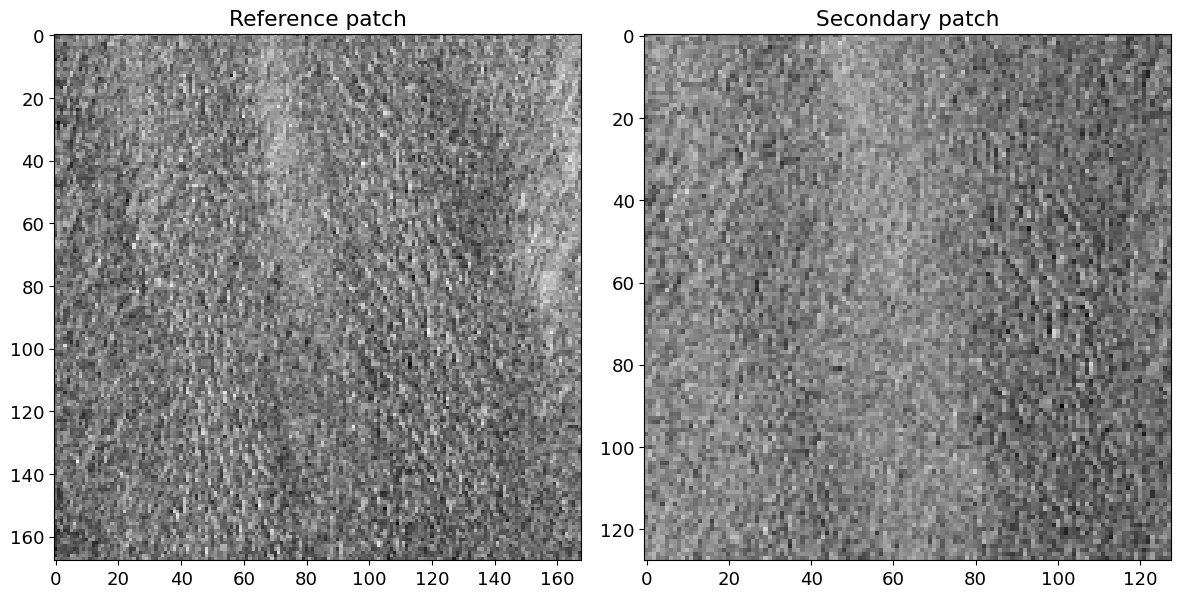

In [3]:
# Load 128x128 secondary (template patch)
sec_patch = np.load(os.path.join(parent_dir, 'support_files', 'sec_patch.npy'))
win_size = sec_patch.shape[0]

# Load 128x128 reference patch, which also includes a 20 pixel buffer for the search window
ref_patch = np.load(os.path.join(parent_dir, 'support_files', 'ref_patch.npy'))
search_win = (ref_patch.shape[0] - win_size) // 2

# Remove mean value from patches
ref_patch -= np.mean(ref_patch)
sec_patch -= np.mean(sec_patch)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))
im1 = ax1.imshow(ref_patch, cmap='gray')
im2 = ax2.imshow(sec_patch, cmap='gray')
im2.set_clim(im1.get_clim())
ax1.set_title('Reference patch')
ax2.set_title('Secondary patch')
fig.set_tight_layout(True)

To demonstrate the cross-correlation operation, we will use the match template function implemented in the OpenCV package (https://docs.opencv.org/4.5.2/d4/dc6/tutorial_py_template_matching.html) which outputs a correlation surface between a reference and template patch. This function and the underlying cross-correlation operation implemented in ISCE are quite similar, although ISCE implements additional machinery specifically for SLC images with varying frequency content.

Integer shifts: 0 3


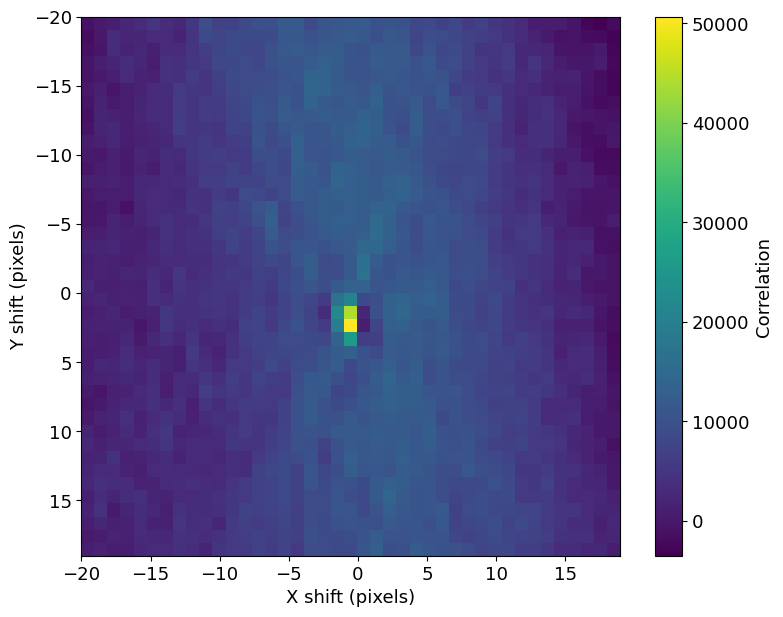

In [4]:
import cv2 as cv

# Call OpenCV template matching to get a correlation surface
correlation = cv.matchTemplate(ref_patch.astype(np.float32),
                               sec_patch.astype(np.float32),
                               cv.TM_CCOEFF)

# Construct arrays corresponding to the offset values
xoff = np.arange(-search_win, search_win, 1)
yoff = np.arange(-search_win, search_win, 1)

# Find the integer offset
indmax = np.argmax(correlation)
row_max, col_max = np.unravel_index(indmax, correlation.shape)

# Get the corresponding shift
max_xoffset = xoff[col_max]
max_yoffset = yoff[row_max]
print('Integer shifts:', max_xoffset, max_yoffset)

fig, ax = plt.subplots(figsize=(9, 7))
im = ax.imshow(correlation, extent=[xoff[0], xoff[-1], yoff[-1], yoff[0]])
cbar = plt.colorbar(im, ax=ax, orientation='vertical')
cbar.set_label('Correlation')
ax.set_xlabel('X shift (pixels)');
ax.set_ylabel('Y shift (pixels)');

From the correlation surface, we can see a fairly concentrated peak at a coordinate of $\Delta X$ = 0 pixels and $\Delta Y$ = 3 pixels, which indicates most of the shift is in the azimuth direction. For most applications, we want to get *sub-pixel* resolution in the offsets. One way to achieve this is oversample the correlation surface. In ISCE, this is done in the frequency domain for computational efficiency, but here, we will use a simple interpolation routine as an example. Note that we extract a small sub-window around the peak correlation value prior to oversampling.

Coarse integer X offset: 0
Coarse integer Y offset: 3
Sub-pixel X offset: -0.1968503937007875
Sub-pixel Y offset: 2.637795275590551


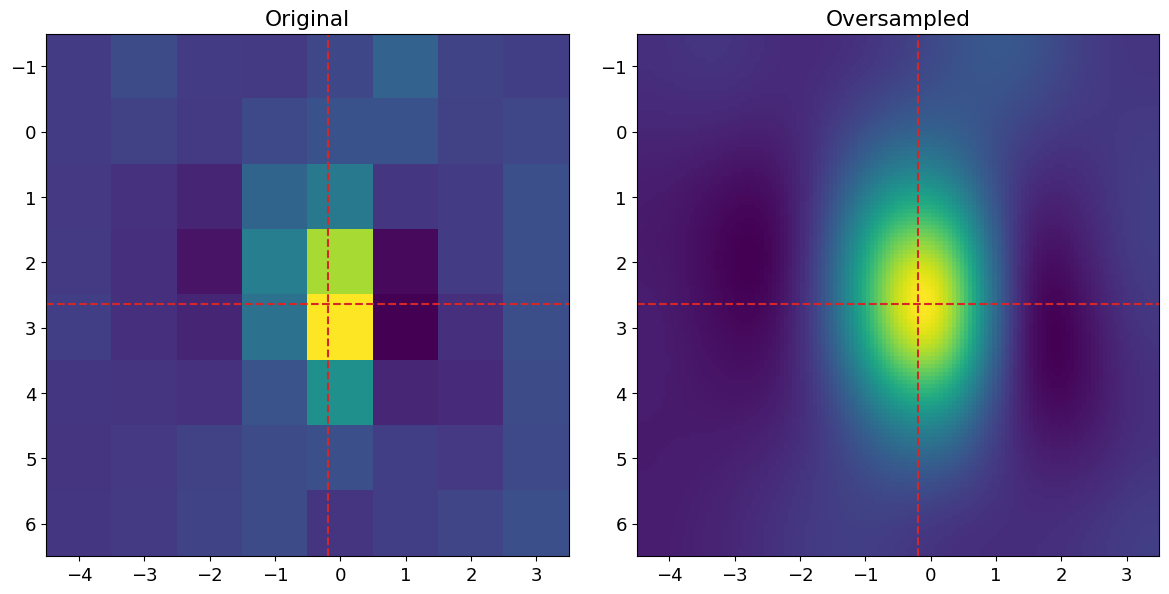

In [5]:
# Index of the peak
peak_index = np.argmax(correlation)
peak_row, peak_col = np.unravel_index(peak_index, correlation.shape)
coarse_dx = peak_col - search_win
coarse_dy = peak_row - search_win
print('Coarse integer X offset:', coarse_dx)
print('Coarse integer Y offset:', coarse_dy)

# Slice a small window
zoom_window = 8
row_slice = slice(peak_row - zoom_window // 2, peak_row + zoom_window // 2)
col_slice = slice(peak_col - zoom_window // 2, peak_col + zoom_window // 2)
correlation_subset = correlation[row_slice, col_slice]

# Call zoom function
zoom_factor = 16
correlation_zoom = ndimage.zoom(correlation_subset, zoom=zoom_factor, prefilter=False, order=4)

# Compute the grid corresponding to the oversampled coordinates CENTERED on peak
# These are the normalized "sub-pixel" coordinates
x = np.linspace(-zoom_window // 2, zoom_window // 2 - 1, zoom_factor * zoom_window)
y = np.linspace(-zoom_window // 2, zoom_window // 2 - 1, zoom_factor * zoom_window) # same as x
X, Y = np.meshgrid(x, y)

# Get index of peak oversampled correlation
peak_zoom_index = np.argmax(correlation_zoom)
peak_zoom_row, peak_zoom_col = np.unravel_index(peak_zoom_index, correlation_zoom.shape)

# Get the sub-pixel offsets
dx = X[peak_zoom_row, peak_zoom_col] + coarse_dx
dy = Y[peak_zoom_row, peak_zoom_col] + coarse_dy
print('Sub-pixel X offset:', dx)
print('Sub-pixel Y offset:', dy)

# Construct the image extent of the sub-window
half_zoom = zoom_window // 2
extent = np.array([-half_zoom + coarse_dx, half_zoom + coarse_dx,
                   half_zoom + coarse_dy, -half_zoom + coarse_dy]) - 0.5

# View the oversampled window next to the original
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

im1 = ax1.imshow(correlation_subset, extent=extent)
im2 = ax2.imshow(correlation_zoom, extent=extent)
# Plot location of sub-pixel peak
for ax in (ax1, ax2):
    ax.axvline(dx, ls='--', color='C3')
    ax.axhline(dy, ls='--', color='C3')

ax1.set_title('Original')
ax2.set_title('Oversampled')
fig.set_tight_layout(True)


After oversampling of the correlation surface by a factor 16, we now estimate $\Delta X$ = -0.20 pixels and $\Delta Y$ = 2.64 pixels. Note that the oversampling factor indicates that we can measure the pixel offsets to 1/16th of a pixel. However, this does __not__ mean that the accuracy of the measurement is 1/16th of a pixel. In addition to the signal-to-noise ratio (SNR), the curvature of the correlation surface dictates the overall __uncertainty__ in the offset measurement. When the surface has a sharp peak, the uncertainty is lower. When the surface is more diffuse (spread out), the uncertainty is high. The ISCE dense offset module provides a measurement of this uncertainty via a covariance file `dense_ampcor_cov.bil`, which we will not discuss in this tutorial. Instead, we will utilize measurements of the SNR to mask out offsets with low SNR values.

### Post-processing: masking and filtering offsets

__Once the dense offset computation has completed__, we will do a bit of post-processing on the offsets. Let's write a function to mask out offsets with low SNR values and perform a 2D median filter on the offsets in order to remove high-frequency noise.

In [ ]:
from scipy.ndimage import generic_filter

def mask_filter_offsets(filename, snr_thresh=6.0, filter_size=3):
    """
    Reads in dense offsets output, masks out values with low SNR, performs median filtering,
    and writes out raster file with prefix filt_*.
    
    Parameters
    ----------
    filename: str
        Filename of offset result (.bil file)
    snr_thresh: float, optional
        Minimum valid SNR value. Default: 6.
    filter_size: int, optional
        Window size of median filter. Default: 3.
        
    Returns
    -------
    d1: np.ndarray
        Array of masked and filtered azimuth offsets.
    d2: np.ndarray
        Array of masked and filtered range offsets.
    snr: np.ndarray
        Array of SNR values.
    """
    # Read offsets
    ds = gdal.Open(filename, gdal.GA_ReadOnly)
    d1 = ds.GetRasterBand(1).ReadAsArray()
    d2 = ds.GetRasterBand(2).ReadAsArray()
    transform = ds.GetGeoTransform()
    ds = None
    Ny, Nx = d1.shape
    
    # Read SNR
    ds = gdal.Open(filename.replace('.bil', '_snr.bil'), gdal.GA_ReadOnly)
    snr = ds.GetRasterBand(1).ReadAsArray()
    ds = None
    
    # Mask SNR
    mask = snr < snr_thresh
    d1[mask] = np.nan
    d2[mask] = np.nan
    
    # Perform filtering
    d1 = generic_filter(d1, np.nanmedian, size=filter_size)
    d2 = generic_filter(d2, np.nanmedian, size=filter_size)
    
    # Set masked values to 0 for geocoding compatibility
    d1[mask] = 0
    d2[mask] = 0
    
    # Write to raster
    basename = os.path.basename(filename)
    dirname = os.path.dirname(filename)
    outname = os.path.join(dirname, 'filt_' + basename)
    driver = gdal.GetDriverByName('ISCE')
    ds = driver.Create(outname, xsize=Nx, ysize=Ny, bands=2, eType=gdal.GDT_Float32)
    for band, data in enumerate((d1, d2), start=1):
        b = ds.GetRasterBand(band)
        b.SetNoDataValue(0)
        b.WriteArray(data.astype(np.float32))
    ds = None
    
    # Create VRT for output
    gdal.Translate(outname + '.vrt', outname, format='VRT')
    
    return d1, d2, snr
    
# Mask and filter the offsets
os.chdir(os.path.join(parent_dir, 'stack'))
d1, d2, snr = mask_filter_offsets('merged/dense_offsets/20200112_20200118/20200112_20200118.bil',
                                  snr_thresh=6)

# Let's view the offsets to see if we need to adjust the SNR threshold
d1[d1 == 0] = np.nan
plt.imshow(d1, clim=(0, 10), cmap='turbo')
plt.colorbar(label='Azimuth offset')

In [ ]:
# List the generated offset files in the 'merged' directory
odir = os.path.join(parent_dir, 'stack', 'merged', 'dense_offsets', '20200112_20200118')
!ls -l {odir}

### Post-processing: geocoding

The last step is to geocode the filtered offsets. Here, we'll make use of `geocodeGdal.py`, which requires the merged longitude and latitude files in the reference radar geometry. 

In [ ]:
os.chdir(os.path.join(parent_dir, 'stack', 'merged', 'dense_offsets', '20200112_20200118'))
!rm -f geo_filt*
!geocodeGdal.py -l ../../geom_reference/lat.rdr -L ../../geom_reference/lon.rdr -f filt_20200112_20200118.bil -r bilinear -x 0.00278 -y 0.00278 -b '-76 -74.5 -104 -96'
os.chdir(os.path.join(parent_dir, 'stack'))
!ls -l merged/dense_offsets/20200112_20200118

Let's now call a helper function to plot the geocoded offsets on top of an image of the ice surface provided by the Landsat Image Mosaic of Antarctica (LIMA):

In [ ]:
plot_offsets('merged/dense_offsets/20200112_20200118', parent_dir)

## Generating offsets with autoRIFT

Alternatively to the dense offset computation included in the TOPS processing, we can make use of the `autoRIFT` package (https://github.com/nasa-jpl/autoRIFT), which is a more flexible, standalone package for finding pixel displacements between co-registered images of any format (including optical data). The basic offset computation algorithm is the same as the TOPS dense offsets (2D cross-correlation of image patches), but `autoRIFT` employs the `OpenCV` package to perform the cross-correlation. Moreover, `autoRIFT` allows you to provide land and ocean masks to limit search distances, as well as reference displacement rate maps to set search distances larger in fast moving areas and smaller in slow moving areas (e.g., on and off a fast-flowing glacier). These customizations can significantly reduce computational time compared to the standard dense offsets.

For Sentinel-1 radar data, `autoRIFT` is also packaged with the `Geogrid` module, which helps with transformations between radar and geographic coordinates. Both the `autoRIFT` and `Geogrid` modules are included in ISCE (e.g., `components.contrib.geo_autoRIFT.autoRIFT` and `components.contrib.geo_autoRIFT.geogrid`). For an example on using `autoRIFT` on optical images, see [this](https://github.com/parosen/Geo-SInC/blob/main/UNAVCO2022/4.3_Offset_stack_for_velocity_dynamics_with_autoRIFT/autorift.ipynb) notebook from Forrest Williams.

#### Implementation details

For this notebook, we will be calling functions included in the following Python files:
- `testGeogrid_ISCE.py`
- `testautoRIFT_ISCE.py`
- `hyp3_netcdf_output.py`
- `hyp3_io.py`

The first two files can be downloaded from the `autoRIFT` github repository. The second two files were downloaded from the `hyp3-sdk` repository (https://github.com/ASFHyP3/hyp3-sdk) and prepended with `hyp3_` here in order to distinguish them from similarly named files in the original `autoRIFT` repository. These last two files have some helper functions and are more up-to-date in generating `autoRIFT` outputs.

### Running `Geogrid`

`Geogrid` is designed to compute transformations between pixels in image coordinates (e.g., range and azimuth in radar images, row and column for optical images) to pixels in an output map projection system. The output projection system is controlled by various input files passed into `Geogrid`, which specify spatially-varying parameters like window sizes, search window sizes, reference velocities, topography, and surface slopes __in map coordinates__.

For this tutorial, we will keep things simple by using the DEM that we used for stack processing and cropping and warping the DEM to Polar Stereographic South coordinates (`pig_rema_100m_filled_polar_cropped.tif`). We will then create the necessary input rasters for `Geogrid`, which will simply be rasters filled with constant values with the same map projection as the DEM. The function below implements the input raster generation. Note that the values for `srx`, `sry`, `csx`, and `csy` (defined in the function) were chosen to give us offset parameters that are similar to the ones we used for the TOPS dense offsets.

In [ ]:
# Download DEM first
os.chdir(parent_dir)
!aws --region=us-west-2 --no-sign-request s3 cp s3://asf-jupyter-data-west/pig_rema_100m_filled_polar_cropped.tif .

In [ ]:
def prepare_geogrid_inputs(demfile, srx=1500, sry=1500, csx=960, csy=960):
    """
    Generate the necessary input rasters for Geogrid.
    
    Parameters
    ----------
    demfile: str
        Name of input DEM.
    srx: float, optional
        Search window velocity (m/yr) in the map X-direction. Default: 1500.
    sry: float, optional
        Search window velocity (m/yr) in the map Y-direction. Default: 1500.
    csx: float, optional
        Window size (m) in the map X-direction. Default: 960.
    csy: float, optional
        Window size (m) in the map Y-direction. Default: 960.
    
    Returns
    -------
    None
    """
    # Load DEM elevation array in order to get shapes and geoTransform
    ds = gdal.Open(demfile, gdal.GA_ReadOnly)
    b = ds.GetRasterBand(1)
    h = b.ReadAsArray()
    geoTransform = ds.GetGeoTransform()
    shape = h.shape
    ds = None
    
    # DEM slopes
    write_gdal('dhdx.tif', np.zeros(shape, dtype=np.float32), geoTransform, dtype=gdal.GDT_Float32)
    write_gdal('dhdy.tif', np.zeros(shape, dtype=np.float32), geoTransform, dtype=gdal.GDT_Float32)
    
    # Write chip window size files
    write_gdal('xMinChipSize.tif', csx * np.ones(shape, dtype=np.uint16), geoTransform, dtype=gdal.GDT_UInt16)
    write_gdal('yMinChipSize.tif', csy * np.ones(shape, dtype=np.uint16), geoTransform, dtype=gdal.GDT_UInt16)
    write_gdal('xMaxChipSize.tif', csx * np.ones(shape, dtype=np.uint16), geoTransform, dtype=gdal.GDT_UInt16)
    write_gdal('yMaxChipSize.tif', csy * np.ones(shape, dtype=np.uint16), geoTransform, dtype=gdal.GDT_UInt16)
    
    # Write search ranges
    write_gdal('vxSearchRange.tif', srx * np.ones(shape, dtype=np.int16), geoTransform, dtype=gdal.GDT_Int16)
    write_gdal('vySearchRange.tif', sry * np.ones(shape, dtype=np.int16), geoTransform, dtype=gdal.GDT_Int16)
    
    # Write stable surface mask
    write_gdal('StableSurface.tif', np.zeros(shape, dtype=np.uint8), geoTransform, dtype=gdal.GDT_Byte)
    
    # Write reference velocity field
    write_gdal('vx.tif', np.zeros(shape, dtype=np.float32), geoTransform, dtype=gdal.GDT_Float32)
    write_gdal('vy.tif', np.zeros(shape, dtype=np.float32), geoTransform, dtype=gdal.GDT_Float32)
    
os.chdir(parent_dir)
demfile = 'pig_rema_100m_filled_polar_cropped.tif'
prepare_geogrid_inputs(demfile)

Once those files have been generated, we can run `Geogrid`:

In [ ]:
# Set parameters for the pair we are processing
# Use the same bbox that was used to create the stack
lat_limits = -75.6, -74.4
lon_limits = -104, -96
reference_path = 'stack/merged/SLC/20200112/20200112.slc.full'
secondary_path = 'stack/merged/SLC/20200118/20200118.slc.full'

geogrid_info = {
    'dem':  demfile,
    'ssm': 'StableSurface.tif',
    'dhdx': 'dhdx.tif',
    'dhdy': 'dhdy.tif',
    'srx': 'vxSearchRange.tif',
    'sry': 'vySearchRange.tif',
    'csminx': 'xMinChipSize.tif',
    'csminy': 'yMinChipSize.tif',
    'csmaxx': 'xMaxChipSize.tif',
    'csmaxy': 'yMaxChipSize.tif',
    'vx': 'vx.tif',
    'vy': 'vy.tif'
}

# Load scene
meta_r = loadMetadata('stack/reference')
meta_s = loadMetadata('stack/secondarys/20200118')

# Run Geogrid
geogrid_run_info = runGeogrid(
    meta_r,
    meta_s,
    epsg=3031,
    **geogrid_info
)
# Need to re-register all drivers
gdal.AllRegister()

The `Geogrid` outputs are the varioius `window_*tif` files:

In [ ]:
!ls -l window_*.tif

### Run `autoRIFT`

To run `autoRIFT`, we simply need to pass in the outputs from `Geogrid`:

In [ ]:
# Construct dictionary of inputs to autoRIFT from the outputs of Geogrid
autorift_info = {
    'grid_location': 'window_location.tif',
    'init_offset': 'window_offset.tif',
    'search_range': 'window_search_range.tif',
    'chip_size_min': 'window_chip_size_min.tif',
    'chip_size_max': 'window_chip_size_max.tif',
    'offset2vx': None,
    'offset2vy': None,
    'stable_surface_mask': 'window_stable_surface_mask.tif',
    'scale_factor': 'window_scale_factor.tif',
    'mpflag': 0
}

# Clean any old autoRIFT runs
try:
    os.remove('autoRIFT_intermediate.nc')
except FileNotFoundError:
    pass

# Run autoRIFT
generateAutoriftProduct(
    reference_path,
    secondary_path,
    nc_sensor='S1',
    optical_flag=False,
    ncname=None,
    geogrid_run_info=geogrid_run_info,
    **autorift_info,
    parameter_file=DEFAULT_PARAMETER_FILE.replace('/vsicurl/', ''),
)

The `autoRIFT` output is a file called `offset.tif`, which has four bands in the Polar Stereographic South projection. The first band is the range offsets, the second band is the azimuth offsets, the third band is an interpolation mask, and the fourth band is the window size used in the range direction. To compare the results with the dense offsets from the TOPS stack, let's use `gdalwarp`:

In [ ]:
!gdalwarp -overwrite -dstnodata NaN -t_srs EPSG:4326 -te -104 -76 -96 -74.5 -tr 0.00278 0.00278 -r bilinear -of GTiff offset.tif offset_wgs84.tif

Finally, let's call a helper routine to plot the offsets over the same LIMA image we used before.

In [ ]:
plot_autorift_offsets(parent_dir, filename='offset_wgs84.tif', dt=6.0)

Overall, we can see that the offset field generated by `autoRIFT` is fairly similar to the one generated by the ISCE/TOPS dense offsets module. `autoRIFT` tends to be more aggressive in masking out bad values, but the offsets in the high SNR areas look to be very similar between the two methods.

### Epilogue: utilizing the Hyp3 on-demand service

The ASF Hybrid Pluggable Processing Pipeline (referred to as HyP3) provides a free service where people can request SAR processing on-demand. These processing requests are picked up by automated systems, which handle the complexity of SAR processing on behalf of the user. HyP3 doesn't require users to have a lot of knowledge of SAR processing before getting started; users only need to submit the input data and set a few optional parameters if desired. Currently, HyP3 provides on-demand processing for InSAR pairs, radiometric terrain corrected Sentinel-1 images, and autoRIFT pairs. __NOTE__: the HyP3 autoRIFT jobs are optimized for land ice applications, so the quality of the offset fields may vary for other surface environments.

Jobs can be submitted through ASF Vertex, a REST API (https://hyp3-docs.asf.alaska.edu/using/api/), or using the `hyp3_sdk` Python module (see installation instruction here: https://hyp3-docs.asf.alaska.edu/using/sdk/). The following code is an example of the Python module for submitting, monitoring, and downloading HyP3 autoRIFT jobs for the same data we've been viewing for this tutorial (code adapted from https://nbviewer.org/github/ASFHyP3/hyp3-sdk/blob/main/docs/sdk_example.ipynb):

```python
import hyp3_sdk as sdk

# Enter Earthdata credentials
hyp3 = sdk.HyP3(prompt=True)

# Specify the Sentinel-1 ESA granule IDs for the pairs we wish to process
# Each pair is a tuple
autorift_pairs = [
    # The original pair in this notebook
    ('S1A_IW_SLC__1SSH_20200112T043556_20200112T043623_030762_038717_3E04',
     'S1B_IW_SLC__1SSH_20200118T043514_20200118T043541_019866_025927_DD28'),
    # An additional pair with a longer repeat time
    ('S1A_IW_SLC__1SSH_20200112T043556_20200112T043623_030762_038717_3E04',
     'S1A_IW_SLC__1SSH_20200124T043556_20200124T043623_030937_038D3B_0851')
]

# Submit the autorift jobs
autorift_jobs = sdk.Batch()
for reference, secondary in autorift_pairs:
    autorift_jobs += hyp3.submit_autorift_job(reference, secondary, name='autorift-example')
print(autorift_jobs)

# Monitor job status
autorift_jobs = hyp3.watch(autorift_jobs)

# Download finished jobs
autorift_jobs = hyp3.refresh(autorift_jobs)
succeeded_jobs = autorift_jobs.filter_jobs(succeeded=True, running=False, failed=False)
file_list = succeeded_jobs.download_files()
```

We have submitted and downloaded the outputs from the above jobs. They can be downloaded from the S3 bucket and extracted here:

In [ ]:
os.chdir(parent_dir)
!aws --region=us-west-2 --no-sign-request s3 cp s3://asf-jupyter-data-west/hyp3_autorift.tar.gz .
!tar -xvzf hyp3_autorift.tar.gz
print('')
!ls -l S1A*nc

As we can see, the output `.nc` files are stored in the netCDF format. We can actually use HDF5 tools to query the files and read the data.

In [ ]:
f1 = 'S1A_IW_SLC__1SSH_20200112T043556_20200112T043623_030762_038717_3E04_X_S1B_IW_SLC__1SSH_20200118T043514_20200118T043541_019866_025927_DD28_G0120V02_P055_IL_ASF_OD.nc'
f2 = 'S1A_IW_SLC__1SSH_20200112T043556_20200112T043623_030762_038717_3E04_X_S1A_IW_SLC__1SSH_20200124T043556_20200124T043623_030937_038D3B_0851_G0120V02_P030_IL_ASF_OD.nc'
!h5ls {f1}

Let's load the autoRIFT results for our original date pair. As with the dense offset and autoRIFT outputs above, we will look at the offsets in the azimuth and range directions (datasets `va` and `vr` in the netCDF files, respectively). However, the offsets are provided in the Polar Stereographic South projection, so if you want to do a direct comparison, you'll have to perform a projection transformation yourself. It's also important to reiterate that autoRIFT allows for the range and azimuth offsets to be rotated to horizontal velocities in the output map projection (e.g., Polar Stereographic) by using a surface-parallel flow assumption. The HyP3 processing turns on rotation by default, and those velocities are stored in the `vx` and `vy` datasets.

In [ ]:
import h5py

# Load offsets in polar stereographic coordinates
with h5py.File(f1, 'r') as fid:
    x = fid['x'][()]
    y = fid['y'][()]
    # Load the range and azimuth velocities and convert units to m/day
    va = fid['va'][()].astype(np.float32) / 365
    vr = fid['vr'][()].astype(np.float32) / 365
    
# Mask bad values
mask = np.abs(va) > 20
va[mask] = np.nan
vr[mask] = np.nan
    
extent = 1.0e-3 * np.array([x[0], x[-1], y[-1], y[0]])

fig, axes = plt.subplots(nrows=2, figsize=(8, 10))
ax1, ax2 = axes

im1 = ax1.imshow(vr, aspect='auto', cmap='RdBu_r', extent=extent, clim=(-1.7, 1.7))
im2 = ax2.imshow(va, aspect='auto', cmap='RdBu_r', extent=extent, clim=(-12.5, 12.5))
plt.colorbar(im1, ax=ax1, pad=0.02, label='Vx (m/yr)')
plt.colorbar(im2, ax=ax2, pad=0.02, label='Vy (m/yr)')
for ax in axes:
    ax.set_xlabel('X (km)')
    ax.set_ylabel('Y (km)')

plt.tight_layout()

## Example velocity time series over PIG from 2015 - 2021

Courtesy of Ian Joughin at the University of Washington (NASA MEaSUREs project), we have obtained a stack of horizontal velocities over PIG from 2015-2021. These maps were generated using similar dense offset techniques applied to Sentinel-1 A/B SLCs in order to form monthly velocity mosaics. Let's look at a longer time series (horizontal velocity magnitude) for the same location on the ice shelf we viewed in the previous plot. Additionally, we will perform a more sophisticated time series fit that simultaneously models short- and long-term variations in the time series (Riel, B., Minchew, B. and Joughin, I., 2021, *The Cryosphere*).

<img src="support_files/pig_tseries.png" width=570 height=400 align="left"/>

From the above time series, we can see that the three offset maps we generated occurred in the middle of a long-term speedup event at PIG, which is a consequence of successive large-scale calving events at the ice shelf. As a demonstration of the utility of time series decomposition techniques on a larger scale, let's look at an animation of reconstructed speed changes at PIG (the top plot in the figure above, applied to every pixel), draped over time-varying Sentinel-1 imagery (animation below is in polar stereographic projection, which is rotated roughly 90 degrees from our previous maps). We can clearly see the association between calving events and increases in speed over the ice shelf and near-grounding line ice.

<video controls src="support_files/pig_norm_velocities_sentinel.mp4" width=800 height=400 align="left"/>

## Takeaways

1. Dense offsets are a good choice when:
    - Movement is faster than the maximum detectable by InSAR
    - You know that most of your movement is horizontal
    - You have high-resolution imagery
<br/><br/>   
2. Dense offsets are not a good choice when:
    - Movement is very slow
    - Movement is mostly in the vertical direction
    - You have low-resolution data
    - Your imagery has some banding issues (MUST PRE-PROCESS THE DATA!)
<br/><br/>
3. The ISCE/TOPS dense offsets module is a good choice when:
    - SLC stacks have already been created with topsStack
    - You have no prior information on surface motion
    - You wish to generate offsets with minimal additional configuration
<br/><br/>   
4. The autoRIFT package is a good choice when:
    - You have prior information on surface motion to narrow down your search space
    - Your target of interest is ice flow or landslides
    - You don't have access to many CPUs or a GPU

Additionally, as mentioned above, dense offsets provide measurements in the range and azimuth direction. In glaciology, we often assume surface parallel flow in order to solve for horizontal velocity components from the range and azimuth offsets (as is done with `Geogrid` and `autoRIFT`). In the general case, one would need offsets from a different viewing geometry (e.g., descending vs. ascending pass) in order to solve for 3D surface motion. This will be the topic for Module 4.4 "Decompose velocities from multiple lines of sight".

Finally, we briefly mentioned that uncertainties in the dense offset fields provided by ISCE are stored in the covariance files `dense_offsets_cov.bil`. For scientific applications, it is recommended to geocode these covariance files in order to propagate uncertainties to any subsequent analyses.

<br>
<div class="alert alert-danger">
<font size="4"> <b> <font color='rgba(200,0,0,0.2)'> <u>ASSIGNMENT</u>:  </font> Modify the dense offset parameters and re-run </b> </font>

Modify the window sizes for the ISCE/TOPS dense offsets module by adjusting `ww`, `wh` in the `stack/configs/config_denseOffset_20200112_20200118` file. For example, try reducing the windows by a factor of two. How does this affect the quality of the offset fields? How does this affect the runtime of the dense offset computation? </i></b>.
</div>